# Semi-supervised VAE Model

In [1]:
%matplotlib inline
from keras.layers import Lambda, Input, Dense, BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.utils import np_utils
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, auc
from keras.optimizers import Adam
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import pandas as pd
import time
from tqdm import tqdm

Using TensorFlow backend.


# Dataset

In [2]:
data = pd.read_csv('./data/SVD_dimensionReduction/reduced_column52.csv', index_col=0)
data.shape

(17740, 52)

In [3]:
data = (data - np.mean(data, 0))/ np.sqrt(np.var(data, 0))

In [4]:
autism = pd.read_csv('./data/SVD_dimensionReduction/autism_SVDreduced52_combined.csv', index_col=0)
autism = data.loc[data.index.isin(autism.index),]
autism.shape

(78, 52)

In [5]:
control = pd.read_csv('./data/SVD_dimensionReduction/control_SVDreduced52_combined.csv', index_col=0)
control = data.loc[data.index.isin(control.index),]
control.shape

(154, 52)

In [6]:
prelabel = np.array([1,0])
label = np.repeat(prelabel, [autism.shape[0], control.shape[0]], axis = 0)
label.shape

(232,)

In [7]:
label

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [8]:
combine = [autism,control]
combine = pd.concat(combine)

In [9]:
unlabeldata = data.loc[~data.index.isin(combine.index),]

unlabeldata.shape

(17508, 52)

In [10]:
out_index = np.random.random_integers(0,unlabeldata.shape[0], size = unlabeldata.shape[0] % (3* label.shape[0] /4))

/Users/siying/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 17508 + 1) instead
  """Entry point for launching an IPython kernel.


In [11]:
out_index.shape

(108,)

In [12]:
out_108 = unlabeldata.iloc[out_index,]
out_108.shape

(108, 52)

In [13]:
unlabeldata = unlabeldata.loc[~unlabeldata.index.isin(out_108.index),]
unlabeldata.shape

(17401, 52)

In [14]:
index = np.random.permutation(range(label.shape[0]))
index

array([229, 139, 188, 194, 134, 203,  58, 224, 226, 119, 104, 125,  62,
        16,  31, 110,  41, 116,  59, 218, 219,  20, 198,  93, 223,  79,
       136,  81,  29, 200,  85, 155, 156, 195, 221,  28,  37,  45, 109,
         4, 164,  97,  65, 149, 148, 222,  67, 147,  33,  43, 107, 227,
        72, 172,  46,  23, 111,  10, 169, 178, 118,  44,  14,  18, 186,
         0,   5, 170,  91,  68,  70, 204, 182, 191,  32, 130, 124, 189,
        55, 196,  80, 208, 157,  54, 215,  36, 209, 185, 162, 101, 161,
       131,  78, 129,  87,  56,  75,  99, 231, 140,  73,  49, 192, 150,
       190, 103,  61, 175, 151, 105, 122,  86, 113, 174, 145,  24, 176,
         2,  60, 152, 142, 154, 133,  88,  74, 127,  66,   8,   6,  95,
        25,   9,  27,  57, 153,  69, 181,  94, 217, 123,  71, 100, 120,
       141,  90, 214,  53, 211, 132, 202,  77,  89,   1,  92, 228,  48,
        83, 171,  15, 165, 146, 184, 225,  51, 187, 177, 173,  21,  17,
       201,   3,  34, 143, 117, 144,  19,  22, 230,  96, 135, 12

In [15]:
combine = combine.iloc[index]
label = label[index]

In [16]:
label = pd.DataFrame(label)
label.index = combine.index

In [17]:
combine.shape

(232, 52)

# Network Parameters

In [20]:
original_dim = data.shape[1]
label_dim = 1

input_shape = (original_dim, )
label_shape = (label_dim, )
intermediate_dim = 16
batch_size = 58
latent_dim = 2
epochs = 8
classifier_dim = 1
num_classes = 2

# Encoder Network

In [21]:
# VAE model = encoder + decoder
# encoder model: the encoder is shared by labeled and unlabeled data
x_in = Input(shape=(original_dim,), name='encoder_input')
x_in1 = BatchNormalization()(x_in)
y_in = Input(shape=(label_dim,), name = 'label_input')
x = Dense(intermediate_dim, activation='relu')(x_in1)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Reparameterization Trick for VAE

In [22]:
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Classifier Network

In [23]:
classifier_input = Input(shape=(original_dim,), name= 'classifier_input')
cl1 = Dense(16, activation= 'relu')(x_in1)
#cl2 = Dense(16, activation= 'relu')(cl1)
prob = Dense(1, activation= 'sigmoid')(cl1)

_y_output = prob

# Decoder Network

In [24]:
# labeled decoder
_merged = concatenate([y_in, z])
_merged_latent = Input(shape=(label_dim+latent_dim,), name='merged_z_sampling')
_merged_inter = Dense(intermediate_dim, activation='relu')(_merged)
_merged_output = Dense(original_dim, activation='relu')(_merged_inter)

# unlabeled decoder
u_merged = concatenate([_y_output, z])
u_merged_latent = Input(shape=(label_dim+latent_dim,), name='u_merged_z_sampling')
u_merged_inter = Dense(intermediate_dim, activation='relu')(u_merged)
u_merged_output = Dense(original_dim, activation='relu')(u_merged_inter)

# Loss Function

In [25]:
def kl_loss(x, x_decoded_mean, z_mean=z_mean, z_log_var=z_log_var):
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logxy_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
   
    # p(y) for observed data is equally distributed
    logy = np.log(1. / num_classes)
    
    return xent_loss - logy

def labeled_vae_loss(x, x_decoded_mean):
    return logxy_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)
    

def cls_loss(y, _y_output, N=label.shape[0]):
    alpha = 0.1 * N
    return alpha * binary_crossentropy(y, _y_output)

def unlabeled_vae_loss(x, x_decoded_mean):
    entropy = metrics.categorical_crossentropy(_y_output, _y_output)
    # This is probably not correct, see discussion here: https://github.com/bjlkeng/sandbox/issues/3
    labeled_loss = logxy_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)
    
    return K.mean(K.sum(_y_output * labeled_loss, axis=-1)) + entropy

# Compile Model

In [26]:
# labeled_vae
label_vae = Model(inputs=[x_in,y_in], outputs=[_merged_output, _y_output])
label_vae.compile(optimizer=Adam(lr=0.0001), loss=[labeled_vae_loss, cls_loss])
#label_vae.compile(optimizer=Adam(lr=0.0001), loss=labeled_vae_loss)
label_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 52)           0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 52)           208         encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           848         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            34          dense_2[0][0]                    
__________________________________________________________________________________________________
z_log_var 

In [27]:
# unlabeled_vae
unlabeled_vae = Model(inputs=x_in, outputs=u_merged_output)
unlabeled_vae.compile(optimizer='adam', loss=unlabeled_vae_loss)
unlabeled_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 52)           0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 52)           208         encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           848         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           848         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
z_mean (De

In [28]:
classifier = Model(inputs=[x_in], outputs=[_y_output])

# Fit Model

In [29]:
from tqdm import tnrange, tqdm_notebook
def fit_model(X_unlabeled, X_labeled, y_labeled, epochs):
    #assert len(X_unlabeled) % len(X_labeled) == 0, \
    #       (len(X_unlabeled), batch_size, len(X_labeled))
    start = time.time()
    history = []
    
    for epoch in tnrange(epochs):
        unlabeled_index = np.arange(len(X_unlabeled))
        np.random.shuffle(unlabeled_index)
        
        auc = []
        # Repeat the labeled data to match length of unlabeled data
        labeled_index = []
        for i in range(len(X_unlabeled) // len(X_labeled)):
            l = np.arange(len(X_labeled))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unlabeled) // batch_size
        
        with tqdm_notebook(batches, leave=True) as pbar:
            for i in range(batches):
                # Labeled
            
                index_range =  labeled_index[i * batch_size:(i+1) * batch_size]    
                loss = label_vae.train_on_batch([X_labeled.iloc[index_range,], y_labeled.iloc[index_range,]],   
                                                [X_labeled.iloc[index_range,], y_labeled.iloc[index_range,]]) 
                
                pred = classifier.predict(X_labeled.iloc[index_range,], batch_size=batch_size)
                
                auc.append(roc_auc_score(y_labeled.iloc[index_range, ], pred)) 
                
                # Unlabeled
                index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
                loss += [unlabeled_vae.train_on_batch(X_unlabeled.iloc[index_range,],  X_unlabeled.iloc[index_range,])]
                
                pbar.desc = 'Loss: %s' % loss
                history.append(loss)
                pbar.update(1)
                
        auc_mean = np.mean(auc)
        print(' * Roc_auc_train: %.1f %%' % (100. * auc_mean)) 
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history

Fitting with sample_size: 232


A Jupyter Widget

A Jupyter Widget

 * Roc_auc_train: 68.4 %


A Jupyter Widget

 * Roc_auc_train: 80.9 %


A Jupyter Widget

 * Roc_auc_train: 84.0 %


A Jupyter Widget

 * Roc_auc_train: 86.3 %


A Jupyter Widget

 * Roc_auc_train: 87.9 %


A Jupyter Widget

 * Roc_auc_train: 89.0 %


A Jupyter Widget

 * Roc_auc_train: 89.8 %


A Jupyter Widget

 * Roc_auc_train: 90.9 %

('Elapsed: ', 34.167587995529175)


A Jupyter Widget

A Jupyter Widget

 * Roc_auc_train: 87.9 %


A Jupyter Widget

 * Roc_auc_train: 89.7 %


A Jupyter Widget

 * Roc_auc_train: 91.2 %


A Jupyter Widget

 * Roc_auc_train: 92.5 %


A Jupyter Widget

 * Roc_auc_train: 92.9 %


A Jupyter Widget

 * Roc_auc_train: 93.9 %


A Jupyter Widget

 * Roc_auc_train: 94.4 %


A Jupyter Widget

 * Roc_auc_train: 95.0 %

('Elapsed: ', 30.332669019699097)


A Jupyter Widget

A Jupyter Widget

 * Roc_auc_train: 92.9 %


A Jupyter Widget

 * Roc_auc_train: 93.8 %


A Jupyter Widget

 * Roc_auc_train: 94.3 %


A Jupyter Widget

 * Roc_auc_train: 94.6 %


A Jupyter Widget

 * Roc_auc_train: 94.8 %


A Jupyter Widget

 * Roc_auc_train: 95.1 %


A Jupyter Widget

 * Roc_auc_train: 95.1 %


A Jupyter Widget

 * Roc_auc_train: 95.5 %

('Elapsed: ', 28.872174978256226)


A Jupyter Widget

A Jupyter Widget

 * Roc_auc_train: 95.1 %


A Jupyter Widget

 * Roc_auc_train: 96.0 %


A Jupyter Widget

 * Roc_auc_train: 96.7 %


A Jupyter Widget

 * Roc_auc_train: 96.3 %


A Jupyter Widget

 * Roc_auc_train: 96.0 %


A Jupyter Widget

 * Roc_auc_train: 96.4 %


A Jupyter Widget

 * Roc_auc_train: 96.8 %


A Jupyter Widget

 * Roc_auc_train: 96.5 %

('Elapsed: ', 30.49074387550354)
 * Fit time elapsed: 124.9s


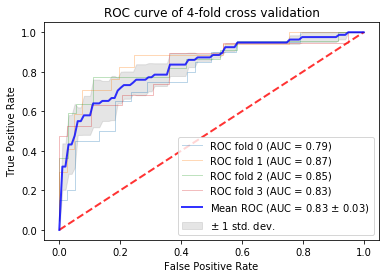

In [30]:
sample_size = label.shape[0]
start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))

#if sample_size < len(x_train):
#   sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(x_train), random_state=0)
#    _, index = sss.split(x_train, y_train)
#    X, y = x_train.iloc[index[1],], y_train[index[1]]
#    X_others, _ = x_train.iloc[index[0],], y_train[index[0]]
#else:

from scipy import interp
from itertools import cycle
from sklearn.model_selection import KFold

cv = KFold(n_splits=4)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(combine, label):
    
        X, y = combine.iloc[train, ], label.iloc[train, ]

        history = fit_model(unlabeldata, X, y, epochs=epochs)

        #classifier = Model(inputs=[x_in], outputs=[_y_output])

        y_pred = classifier.predict(combine.iloc[test,])
        
            
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(label.iloc[test,], y_pred[:,0])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of 4-fold cross validation')
plt.legend(loc="lower right")
#plt.show()
plt.savefig('./plot/ssVAE_epo8_combined52_4ROC.pdf', bbox_inches = 'tight')

end = time.time()
elapsed = end - start
#print(' * Roc_auc: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)


In [31]:
prediction = classifier.predict(data)

In [33]:
prediction.shape

(17740, 1)

In [34]:
prediction = pd.DataFrame(prediction)

In [35]:
prediction.index = data.index

In [36]:
prediction.columns = ['ssVAE_score']

In [39]:
prediction.to_csv("./data/SVD_dimensionReduction/ssVAE_52_prediction.csv")